In [1]:
!unzip "/content/CS436-Week3.zip"

Archive:  /content/CS436-Week3.zip
  inflating: CS436-Week3/bundle_adjustment.py  
   creating: CS436-Week3/data/
   creating: CS436-Week3/data/bed_corner/
  inflating: CS436-Week3/data/bed_corner/img_012.jpeg  
  inflating: CS436-Week3/data/bed_corner/img_013.jpeg  
  inflating: CS436-Week3/data/bed_corner/img_014.jpeg  
  inflating: CS436-Week3/data/bed_corner/img_015.jpeg  
  inflating: CS436-Week3/data/bed_corner/img_016.jpeg  
  inflating: CS436-Week3/data/bed_corner/img_017.jpeg  
  inflating: CS436-Week3/data/bed_corner/img_018.jpeg  
  inflating: CS436-Week3/data/bed_corner/img_019.jpeg  
  inflating: CS436-Week3/data/bed_corner/img_020.jpeg  
  inflating: CS436-Week3/data/bed_corner/img_021.jpeg  
  inflating: CS436-Week3/data/bed_corner/img_022.jpeg  
  inflating: CS436-Week3/data/bed_corner/img_023.jpeg  
   creating: CS436-Week3/data/blackboard_corner/
  inflating: CS436-Week3/data/blackboard_corner/img_024.jpeg  
  inflating: CS436-Week3/data/blackboard_corner/img_025.jpeg

In [2]:
import sys
sys.path.append("/content/CS436-Week3")

In [3]:
# ==============================================================
# SuperGlue Matcher (PyTorch + SuperPoint + SuperGlue)
# ==============================================================

import torch
import sys
import os

# Clone SuperGlue repo if not already present
if not os.path.exists("superglue_pretrained"):
    !git clone https://github.com/magicleap/SuperGluePretrainedNetwork.git superglue_pretrained

# Add cloned repo to path
sys.path.append("superglue_pretrained")

# Import necessary modules
from models.matching import Matching
from models.utils import frame2tensor

# Select best device available
if torch.backends.mps.is_available():
    device = torch.device("mps")   # Apple Silicon GPU
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")   # CPU fallback

print(f"⚡ Using device: {device}")

# Load SuperGlue + SuperPoint models with pretrained weights
config = {
    'superpoint': {
        'nms_radius': 4,
        'keypoint_threshold': 0.005,
        'max_keypoints': 1024
    },
    'superglue': {
        'weights': 'outdoor',
        'sinkhorn_iterations': 20,
        'match_threshold': 0.2
    }
}

matching = Matching(config).eval().to(device)

Cloning into 'superglue_pretrained'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 185 (delta 0), reused 0 (delta 0), pack-reused 184 (from 2)
Receiving objects: 100% (185/185), 118.85 MiB | 28.17 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Updating files: 100% (89/89), done.
⚡ Using device: cpu
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


In [5]:
import cv2
import numpy as np
from feature_matching_glue import match_pairs, load_image, detect_and_compute, match_features
import glob

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


In [15]:
import numpy as np
import cv2
import glob
from bundle_adjustment import do_BA

img = cv2.imread("/content/CS436-Week3/new_data/new_bed_corner/img_14.jpg")

img_height, img_width = img.shape[:2]

sensor_diagonal_mm = 9.2
sensor_width_mm  = sensor_diagonal_mm * 4/5
sensor_height_mm = sensor_diagonal_mm * 3/5

equiv_focal_mm = 27.0
full_frame_diag = 43.27

physical_f_mm = equiv_focal_mm * (sensor_diagonal_mm / full_frame_diag)

fx = (physical_f_mm / sensor_width_mm) * img_width
fy = (physical_f_mm / sensor_height_mm) * img_height

cx = img_width / 2
cy = img_height / 2

K = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1]
], dtype=np.float64)

print("Physical focal length (mm):", physical_f_mm)
print("\nIntrinsic matrix K:\n", K)

image_paths = sorted(glob.glob("/content/CS436-Week3/new_data/new_bed_corner/*.jpg"))

def load_image(path):
    img_color = cv2.imread(path)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    return img_color, img_gray


img1_color, img1_gray = load_image(image_paths[0])
img2_color, img2_gray = load_image(image_paths[1])

kp1, des1, norm = detect_and_compute(img1_gray)   
kp2, des2, _    = detect_and_compute(img2_gray)   


assert isinstance(des1, np.ndarray) and des1.ndim == 2, "des1 must be (N,D) ndarray"
assert isinstance(des2, np.ndarray) and des2.ndim == 2, "des2 must be (N,D) ndarray"
assert len(kp1) == des1.shape[0] and len(kp2) == des2.shape[0], "kp and desc lengths must match"

matches = match_features(des1, des2, norm)

match_qidx = [int(m.queryIdx) for m in matches]
match_tidx = [int(m.trainIdx) for m in matches]

pts1 = np.float32([kp1[i].pt for i in match_qidx])
pts2 = np.float32([kp2[i].pt for i in match_tidx])

E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
if mask is None:
    raise RuntimeError("Essential matrix estimation failed (mask is None)")

inliers1 = pts1[mask.ravel() == 1]
inliers2 = pts2[mask.ravel() == 1]

_, R, t, mask_pose = cv2.recoverPose(E, inliers1, inliers2, K)
R_prev, t_prev = R, t
kp_prev, des_prev = kp2, des2

camera_1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
camera_2 = K @ np.hstack((R, t))

points_4D = cv2.triangulatePoints(camera_1, camera_2, inliers1.T, inliers2.T)
triangulated_points_3D = (points_4D[:3] / points_4D[3]).T
print("Initial triangulated points:", triangulated_points_3D.shape)

map_points_3d = triangulated_points_3D.copy()

z_cam1 = triangulated_points_3D[:, 2]
z_cam2 = (R @ triangulated_points_3D.T + t).T[:, 2]
mask_ = (z_cam1 > 0) & (z_cam2 > 0)
triangulated_points_3D = triangulated_points_3D[mask_]
print("After positive-depth mask:", triangulated_points_3D.shape)

class Point3D_with_views:
    def __init__(self, point3d):
        self.point3d = np.asarray(point3d, dtype=np.float64).reshape(3,)
        self.source_2dpt_idxs = {}

map_points = []        
map_points_obj = []    

all_keypoints = []
all_keypoints.append(kp1)   
all_keypoints.append(kp_prev)

inlier_indices_mask = mask.ravel().astype(bool)

inlier_qidx_full = np.array([match_qidx[i] for i in range(len(match_qidx)) if inlier_indices_mask[i]])
inlier_tidx_full = np.array([match_tidx[i] for i in range(len(match_tidx)) if inlier_indices_mask[i]])

inlier_qidx = inlier_qidx_full[mask_]
inlier_tidx = inlier_tidx_full[mask_]

for k in range(len(triangulated_points_3D)):
    p3d = triangulated_points_3D[k]
    qidx = int(inlier_qidx[k])
    tidx = int(inlier_tidx[k])

    desc_vec = des1[qidx].astype(np.float32)  
    map_points.append({
        "point_3d": p3d,
        "descriptor": desc_vec,
        "kp": tuple(kp1[qidx].pt)
    })

    pt_obj = Point3D_with_views(p3d)
    pt_obj.source_2dpt_idxs[0] = qidx
    pt_obj.source_2dpt_idxs[1] = tidx
    map_points_obj.append(pt_obj)

camera_poses = {}
camera_poses[0] = (np.eye(3), np.zeros((3,1)))
camera_poses[1] = (R, t)

for i in range(2, len(image_paths)):
    print(f"\nProcessing image {i+1}/{len(image_paths)}")

    img_color, img_gray = load_image(image_paths[i])
    kp_i, des_i, _ = detect_and_compute(img_gray)  
    if des_i is None or len(des_i) == 0:
        print("No descriptors in image", i)
        continue

    all_keypoints.append(kp_i)

    map_des = np.array([mp["descriptor"] for mp in map_points], dtype=np.float32)
    map_3d  = np.array([mp["point_3d"] for mp in map_points], dtype=np.float64)

    if map_des.shape[0] == 0:
        print("Map empty, skipping PnP for image", i)
        continue

    matches_2d3d = match_features(des_i, map_des, cv2.NORM_L2)

    if len(matches_2d3d) < 6:
        print(f"Not enough 2D-3D matches for PnP on image {i}: {len(matches_2d3d)}")
        continue

    pts2d = np.float32([ kp_i[int(m.queryIdx)].pt for m in matches_2d3d ])
    pts3d = np.float32([ map_3d[int(m.trainIdx)] for m in matches_2d3d ])

    ok, rvec, tvec, inliers = cv2.solvePnPRansac(
        pts3d, pts2d, K, None,
        reprojectionError=8.0,
        confidence=0.999,
        flags=cv2.SOLVEPNP_ITERATIVE
    )
    if (inliers is None) or (len(inliers) < 6):
        print(f"Image {i}: PnP failed or too few inliers ({0 if inliers is None else len(inliers)})")
        des_prev = des_i
        kp_prev = kp_i
        continue

    R_i, _ = cv2.Rodrigues(rvec)
    t_i = tvec.reshape(3,1)
    camera_poses[i] = (R_i, t_i)
    print(f"Image {i}: Pose estimated with {len(inliers)} inliers")

    bf = cv2.BFMatcher(cv2.NORM_L2)
    if des_prev is None or len(des_prev) == 0:
        des_prev = des_i
        kp_prev = kp_i
        R_prev, t_prev = R_i, t_i
        continue

    prev_matches = match_features(des_prev, des_i, cv2.NORM_L2)

    good = prev_matches
    if len(good) < 6:
        print("Not enough prev<->curr matches to triangulate")
        des_prev = des_i; kp_prev = kp_i; R_prev, t_prev = R_i, t_i
        continue

    pts_prev = np.float32([ kp_prev[int(m.queryIdx)].pt for m in good ])
    pts_curr = np.float32([ kp_i[int(m.trainIdx)].pt for m in good ])

    P_prev = K @ np.hstack((R_prev, t_prev))
    P_curr = K @ np.hstack((R_i, t_i))

    points4D = cv2.triangulatePoints(P_prev, P_curr, pts_prev.T, pts_curr.T)
    points3D = (points4D[:3] / points4D[3]).T

    z_prev = points3D[:, 2]
    z_curr = (R_i @ points3D.T + t_i).T[:, 2]
    mask_z = (z_prev > 0) & (z_curr > 0)

    points3D = points3D[mask_z]
    pts_curr = pts_curr[mask_z]
    good = np.array(good)[mask_z]

    for idx_pt, P in enumerate(points3D):
        m = good[idx_pt]
        train_idx = int(m.trainIdx)
        query_idx = int(m.queryIdx)

        desc_vec = des_i[train_idx].astype(np.float32)

        map_points.append({
            "point_3d": P,
            "descriptor": desc_vec,
            "kp": tuple(kp_i[train_idx].pt)
        })

        pt_obj = Point3D_with_views(P)
        prev_img_idx = i-1
        pt_obj.source_2dpt_idxs[prev_img_idx] = query_idx   
        pt_obj.source_2dpt_idxs[i] = train_idx             
        map_points_obj.append(pt_obj)

    print(f"Added {len(points3D)} new 3D points to map.")

    R_prev, t_prev = R_i, t_i
    kp_prev, des_prev = kp_i, des_i

R_mats = {idx: camera_poses[idx][0] for idx in camera_poses}
t_vecs = {idx: camera_poses[idx][1] for idx in camera_poses}
resected_imgs = sorted(list(camera_poses.keys()))

points_for_BA = [pt for pt in map_points_obj if len(pt.source_2dpt_idxs) >= 2]

if len(points_for_BA) >= 6:
    map_points_after_adjustment, R_mats, t_vecs = do_BA(
        points3d_with_views=points_for_BA,
        R_mats=R_mats,
        t_vecs=t_vecs,
        resected_imgs=resected_imgs,
        keypoints=all_keypoints,
        K=K,
        ftol=1e-6
    )
else:
    print("Not enough points for BA")


Physical focal length (mm): 5.740697943147676

Intrinsic matrix K:
 [[9.35983360e+02 0.00000000e+00 6.00000000e+02]
 [0.00000000e+00 1.66397042e+03 8.00000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Initial triangulated points: (412, 3)
After positive-depth mask: (412, 3)

Processing image 3/15
Not enough 2D-3D matches for PnP on image 2: 4

Processing image 4/15
Not enough 2D-3D matches for PnP on image 3: 2

Processing image 5/15
Not enough 2D-3D matches for PnP on image 4: 3

Processing image 6/15
Not enough 2D-3D matches for PnP on image 5: 2

Processing image 7/15
Not enough 2D-3D matches for PnP on image 6: 3

Processing image 8/15
Image 7: Pose estimated with 6 inliers
Added 204 new 3D points to map.

Processing image 9/15
Image 8: Pose estimated with 34 inliers
Added 621 new 3D points to map.

Processing image 10/15
Image 9: Pose estimated with 32 inliers
Added 410 new 3D points to map.

Processing image 11/15
Image 10: Pose estimated with 49 inliers
Added 415 new

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def compute_reprojection_errors(map_points, R_mats, t_vecs, all_keypoints, K):
    errors = []

    for mp in map_points:
        X = mp.point3d.reshape(3, 1)

        for cam_idx, kp_idx in mp.source_2dpt_idxs.items():
          if cam_idx in R_mats and cam_idx in t_vecs:
            R = R_mats[cam_idx]
            t = t_vecs[cam_idx]

            P = K @ np.hstack([R, t])
            X_h = np.vstack([X, 1])
            proj = P @ X_h
            proj = proj[:2] / proj[2]

            kp = np.array(all_keypoints[cam_idx][kp_idx].pt)

            err = np.linalg.norm(proj.flatten() - kp)
            errors.append(err)

    return np.array(errors)

In [17]:
reprojection_errors = compute_reprojection_errors(
    map_points_after_adjustment,
    R_mats,
    t_vecs,
    all_keypoints,
    K
)

print("Mean reprojection error:", np.mean(reprojection_errors))
print("Max reprojection error:", np.max(reprojection_errors))

Mean reprojection error: 32.30514721839514
Max reprojection error: 197.2993511342375


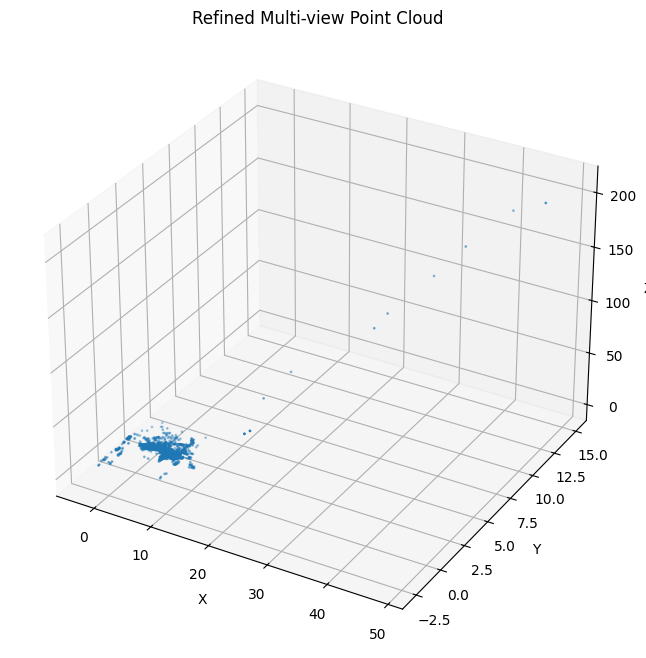

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


points = np.array([mp.point3d for mp in map_points_after_adjustment])
points = points.squeeze()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Refined Multi-view Point Cloud")

plt.show()

In [11]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.8 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [12]:
import open3d as o3d

In [19]:
pcd = o3d.geometry.PointCloud()

pcd.points = o3d.utility.Vector3dVector(points)

o3d.io.write_point_cloud("/content/CS436-Week3/pcd_bed_2.ply", pcd, write_ascii = True)

True

In [35]:
print(R_mats)

{0: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), 1: array([[ 0.96890155,  0.02602992, -0.23309731],
       [-0.02268321,  1.01035477,  0.01969646],
       [ 0.23349437, -0.01408309,  0.96963571]]), 7: array([[ 0.90973395,  0.09232613, -0.50223148],
       [-0.11862025,  1.07242642, -0.12407149],
       [ 0.50398711,  0.17975226,  0.90342015]]), 8: array([[ 0.88979336,  0.00280725, -0.52449406],
       [-0.10526456,  0.95463662, -0.17313929],
       [ 0.52091386,  0.19816974,  0.84953343]]), 9: array([[ 1.07541226, -0.02737713, -0.27501167],
       [-0.02261494,  1.02180874, -0.14394148],
       [ 0.27610433,  0.14602152,  1.03602012]]), 10: array([[ 0.71821452,  0.10664302, -0.68122696],
       [-0.13220695,  0.97231541, -0.13415672],
       [ 0.6735666 ,  0.19082965,  0.69949001]]), 11: array([[ 0.49166451,  0.14399822, -0.85317467],
       [-0.14479434,  0.84708085, -0.05266798],
       [ 0.82881594,  0.14621953,  0.49182037]]), 12: array([[ 0.14444189,  0.0640434

In [20]:
import json
import os

cameras = []

for cam_id in sorted(R_mats.keys()):
    R = R_mats[cam_id].tolist()
    t = t_vecs[cam_id].flatten().tolist()

    image_name = os.path.basename(image_paths[cam_id]) if cam_id < len(image_paths) else None

    cameras.append({
        "id": int(cam_id),
        "image": image_name,
        "rotation": R,
        "translation": t
    })

camera_data = {"cameras": cameras}

output_path = "/content/CS436-Week3/cameras_bed_2.json"
with open(output_path, "w") as f:
    json.dump(camera_data, f, indent=2)

print(f"✅ Saved {len(cameras)} cameras to {output_path}")


✅ Saved 8 cameras to /content/CS436-Week3/cameras_bed_2.json
